## Data overview:
You are provided with unlabeled data for which labeling is to be computed. There are 20 subjects of fMRI scan in total, for each subject there are 16 (2x2x2x2) representations corresponding to – two different brain atlas partitions (Brainnetome and Schaefer200), times two different smoothing strategies, times two segments of scan sequence, times two different sequences. Shape structure for the dataset translates aas follows `[20*16 objects, 10 timesteps from scan sequence, 246 number of features in larger atlas]`. Note that since two atlases with different number of partitions are used, some data arrays are padded with `np.nan`s, so that data shape is uniform.

*Public Test Data:*

- IHB dataset: 10 subject

*Private Test Data:*

- IHB dataset: 10 subjects

File with all $20 \times 16$ scan data representations is available via this repository lfs.

## Objective
The task aims to simulate a realistic research workflow:

-	Data Collection Constraints: Collecting fMRI data is challenging and costly, resulting in small proprietary datasets.
-	Dataset Variability: These open datasets inherently differ from proprietary data in aspects such as scanner type, geographic location of data collection, and average age of participants. Such aspect are simulated through choice of different brain states, time sequences, atlas-based aggregations.
The primary goal is to develop a model capable of identifying a person using fMRI as a "fingerprint" which is consistent across different perturbations and aspects of data.

## Performance Metric and Deliverables

*Evaluation Metric:* Adjusted Rand Score (rescaled to be between 0.0 for random prediction and worse and 1.0 for perfect labeling: $\text{ari}(y, \hat{y}) = \frac{\text{ri}(y, \hat{y}) - 0.85}{0.15}$)

*Required Deliverables:*
-	`<name>.csv` submission file that contains column named `prediction` which has same integer labels for objects corresponding to same class (subject's fMRI scan).

## Example

**Use standard scaling to account for different scan smoothing strategies, kmeans for computing cluster centers and subsequent distance-based ranking**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
data = np.load('ihb.npy')

In [ ]:
nan_mask = np.any(np.isnan(data), axis=(-2,-1)).astype(bool)
schaefer_data = data[nan_mask]
braintomme_data = data[~nan_mask]

braintomme_data.shape, schaefer_data.shape

((160, 10, 246), (160, 10, 246))

# Unsupervised

In [ ]:
def get_corr(x):
    # (l, d) -> d*(d-1)/2
    cor_mat = np.corrcoef(x, rowvar=False)
    indices = np.triu_indices(cor_mat.shape[0], 1)
    features = cor_mat[indices[0], indices[1]]
    features = np.arctan(features)
    return features

def get_object_features(x):
    win_sizes = [2, 10]
    features = []
    for win_size in win_sizes:
        for i in range(0, 10, win_size):
            features.append(get_corr(x[i*win_size: (i+1)*win_size]))
    return np.vstack(features)

def get_features(x):
    return np.vstack([get_object_features(x_i) for x_i in x])

# def correlation_matrix(x):
#     # x: BxLxD
#     # returns: BxDxD
#     x_norm = x - x.mean(axis=1, keepdims=True)
#     cov = (x_norm[:, :, None, :] * x_norm[:, :, :, None]).sum(axis=1)
#     std_x = np.sqrt((x_norm ** 2).sum(axis=1))
#     cor = cov / std_x[:, None, :] / std_x[:, :, None]
#     return cor

# def get_features(x):
#     # x: BxLxD
#     # returns: Bx(D*(D-1)/2)
#     cor_mat = correlation_matrix(x)
#     indices = np.triu_indices(cor_mat.shape[1], 1)
#     features = cor_mat[:, indices[0], indices[1]]
#     features = np.arctan(features)
#     #return features
#     return (features - features.mean(axis=1, keepdims=True)) / features.std(axis=1, keepdims=True)
get_object_features(braintomme_data[0]).shape

(6, 30135)

In [ ]:
braintomme_features = get_features(braintomme_data)
schaefer_features = get_features(schaefer_data[:, :, :200])

braintomme_features.shape, schaefer_features.shape

((160, 30135), (160, 19900))

In [ ]:
dim = 128
braintomme_pca = PCA(n_components=dim).fit_transform(braintomme_features)
schaefer_pca = PCA(n_components=dim).fit_transform(schaefer_features)

In [ ]:
final_features = np.empty((data.shape[0], dim), dtype=np.float32)
final_features[nan_mask] = schaefer_pca
final_features[~nan_mask] = braintomme_pca

In [ ]:
clustering = SpectralClustering(20, assign_labels="cluster_qr")
#labels = clustering.fit_predict(final_features)
labels = clustering.fit_predict((final_features - final_features.mean(axis=1, keepdims=True)) / final_features.std(axis=1, keepdims=True))

In [ ]:
print(np.asarray(np.unique(labels, return_counts=True)).T)

[[ 0 45]
 [ 1 38]
 [ 2 19]
 [ 3 12]
 [ 4 16]
 [ 5  2]
 [ 6 12]
 [ 7  8]
 [ 8 14]
 [10 44]
 [11  8]
 [12 10]
 [13 12]
 [14 16]
 [15  6]
 [16  8]
 [17 30]
 [18 12]
 [19  8]]


In [ ]:
pd.DataFrame({'prediction': labels}).to_csv('submission.csv', index=False)

# ..............................................................................

80


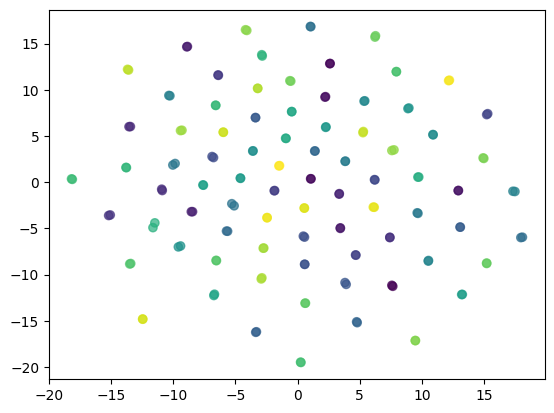

In [ ]:
braintomme_2d = TSNE(2).fit_transform(braintomme_features)
clustering = DBSCAN(eps=1, min_samples=1)
labels = clustering.fit_predict(braintomme_2d)
print(len(set(labels)))
plt.scatter(braintomme_2d[:, 0], braintomme_2d[:, 1], alpha=0.7, c=labels)

80


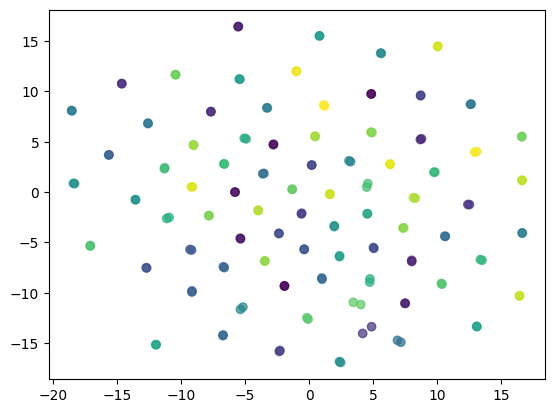

In [ ]:
schaefer_2d = TSNE(2).fit_transform(schaefer_features)
clustering = DBSCAN(eps=1, min_samples=1)
labels = clustering.fit_predict(schaefer_2d)
print(len(set(labels)))
plt.scatter(schaefer_2d[:, 0], schaefer_2d[:, 1], alpha=0.7, c=labels)

138


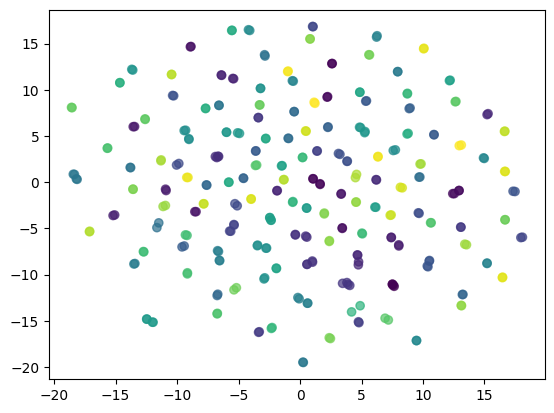

In [ ]:
merged_2d = np.concatenate([braintomme_2d, schaefer_2d])
clustering = DBSCAN(eps=1, min_samples=1)
labels = clustering.fit_predict(merged_2d)
print(len(set(labels)))
plt.scatter(merged_2d[:, 0], merged_2d[:, 1], alpha=0.7, c=labels)

In [ ]:
pca = TSNE(n_components=2)
braintomme_latents = pca.fit_transform(braintomme_features)

pca = TSNE(n_components=2)
schaefer_latents = pca.fit_transform(schaefer_features)

20


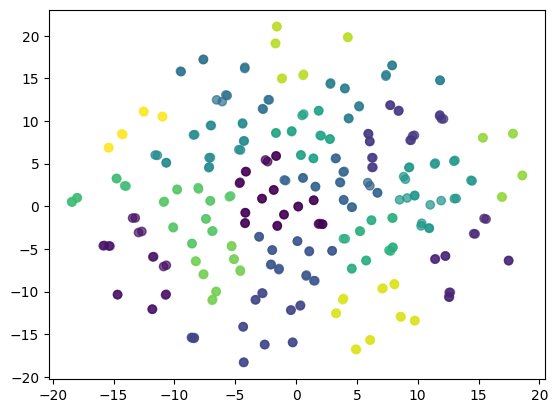

In [ ]:
merged_latents = np.concatenate([braintomme_latents, schaefer_latents])
clustering = AgglomerativeClustering(20)
#clustering = KMeans(20)
labels = clustering.fit_predict(merged_latents)
print(len(set(labels)))
plt.scatter(merged_latents[:, 0], merged_latents[:, 1], alpha=0.7, c=labels)

In [ ]:
print(np.asarray(np.unique(labels, return_counts=True)).T)

[[ 0 28]
 [ 1 18]
 [ 2 14]
 [ 3 20]
 [ 4 20]
 [ 5 18]
 [ 6 20]
 [ 7 14]
 [ 8 14]
 [ 9 18]
 [10 22]
 [11 16]
 [12 16]
 [13  8]
 [14 18]
 [15 14]
 [16  8]
 [17 10]
 [18 16]
 [19  8]]


In [ ]:
pd.DataFrame({'prediction': labels}).to_csv('submission.csv', index=False)

# Self Supervised

In [ ]:
def get_positives(data):
    nearest_neighbour = np.linalg.norm(data[:, None, :, :] - data[None, :, :, :], axis=(-2, -1)).argsort(axis=1)[:, 1]
    indices = list(set([tuple(sorted((i, j))) for i, j in enumerate(nearest_neighbour)]))
    return [(data[i], data[j], 1) for i, j in indices]

def get_negatives(data, n=10):
    farthest_neighbours = np.linalg.norm(data[:, None, :, :] - data[None, :, :, :], axis=(-2, -1)).argsort(axis=1)[:, -n:]
    indices = list(set([tuple(sorted((i, j))) for i, neighbours in enumerate(farthest_neighbours) for j in neighbours]))
    return [(data[i], data[j], 0) for i, j in indices]

triplets = []
triplets.extend(get_positives(braintomme_data))
triplets.extend(get_positives(schaeffer_data))
triplets.extend(get_negatives(braintomme_data))
triplets.extend(get_negatives(schaeffer_data))
len(triplets), min([np.linalg.norm(x-y) for x, y, l in triplets]), max([np.linalg.norm(x-y) for x, y, l in triplets])

(2782, 13.289129, 76.48254)

In [ ]:
class FMRIDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        return self.triplets[idx]

In [ ]:
import math

def pos_encode(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

class AtlasEncoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # self.transformer_encoder = nn.TransformerEncoder(
        #     nn.TransformerEncoderLayer(d_model=input_size, nhead=1),
        # num_layers=1)
        self.input_size = input_size
        self.fc = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(),
            nn.Linear(input_size, output_size)
        )

    def forward(self, x):
        # x has shape (batch_size, sequence_length, input_size)
        #x = self.transformer_encoder(x + pos_encode(self.input_size, 10).to(x.device))
        return self.fc(x)


class SiameseNetwork(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.schaeffer_encoder = AtlasEncoder(200, 200)
        self.braintomme_encoder = AtlasEncoder(246, 200)
        self.fc = nn.Sequential(
            nn.Linear(2000, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, output_size)
        )

    def forward(self, x):
        # x has shape (batch_size, sequence_length, input_size)
        indices = torch.arange(x.shape[0])
        zero_mask = torch.all(torch.isnan(x[:, :, -46:]), dim=(-2, -1))

        schaeffer_x = self.schaeffer_encoder(x[zero_mask][:, :, :200])
        braintomme_x = self.braintomme_encoder(x[~zero_mask])

        x = torch.zeros((x.shape[0], schaeffer_x.shape[1], schaeffer_x.shape[2]), dtype=torch.float32, device=x.device)
        x[zero_mask] = schaeffer_x
        x[~zero_mask] = braintomme_x

        x = self.fc(x.flatten(1))
        return x

#SiameseNetwork(128)(torch.cat([torch.randn((1, 10, 246)), torch.randn((1, 10, 246)), torch.randn((1, 10, 246))])).shape

In [ ]:
# class ContrastiveLoss(nn.Module):
#     def __init__(self, margin=0.5):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, input1, input2, labels):
#         # Normalize each batch of input vectors to have unit length.
#         input1 = F.normalize(input1, p=2, dim=1)
#         input2 = F.normalize(input2, p=2, dim=1)

#         # Compute cosine similarity for each pair (input1, input2).
#         cos_sim = torch.sum(input1 * input2, dim=1)  # Element-wise multiplication followed by summation.

#         # Optionally, apply softmax over similarity values if desired.
#         # Here, each similarity is a single number per pair.
#         probabilities = F.softmax(cos_sim, dim=0)  # Softmax can be queried per pair; however, this is unusual.

#         # Compute contrastive loss
#         # Loss for positive pairs: (1 - cos_sim)^2
#         # Loss for negative pairs: max(0, cos_sim - margin)^2
#         positive_loss = (1 - cos_sim) ** 2
#         negative_loss = F.relu(cos_sim - self.margin) ** 2

#         # Combine losses according to the labels.
#         # If label is 1, use positive_loss. If label is 0, use negative_loss.
#         loss = labels * positive_loss + (1 - labels) * negative_loss

#         # Get diagonal values; this is synthetic as each cos_sim represents one value per pair
#         # and there is no 'matrix' formed naturally in this 1D context.
#         return loss.mean()

class ContrastiveLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, batch_vectors):
        # Normalize the batch vectors to have unit length.
        batch_vectors = F.normalize(batch_vectors, p=2, dim=1)  # L2 normalization.

        # Compute cosine similarity matrix.
        cos_sim_matrix = torch.mm(batch_vectors, batch_vectors.t())  # Cosine similarity.

        # Apply softmax to each row of the cosine similarity matrix.
        softmax_matrix = F.softmax(cos_sim_matrix, dim=1)

        # Extract the diagonal elements.
        diagonal_values = torch.diag(softmax_matrix)

        return diagonal_values

#ContrastiveLoss()(torch.randn((4, 64)), torch.randn((4, 64)), torch.randn((4,)))
ContrastiveLoss()(torch.randn((4, 64)))

torch.Size([4, 4])


tensor([0.4667, 0.4456, 0.4629, 0.4803])

In [ ]:
def get_embeddings(model, data, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x in data:
            embedding = model(x.to(device).unsqueeze(0)).cpu().numpy()
            embeddings.append(embedding)
    return np.vstack(embeddings)

In [ ]:
batch_size = 32
learning_rate = 1e-3
num_epochs = 15
output_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = FMRIDataset(triplets)
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
model = SiameseNetwork(output_size).to(device)
criterion = ContrastiveLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(len(dataset))

2782


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for (x1, x2, label) in dataloader:
        optimizer.zero_grad()
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)

        y1 = model(x1)
        y2 = model(x2)
        loss = criterion(y1, y2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.10f}")

Epoch [1/15], Loss: 0.0253896380
Epoch [2/15], Loss: 0.0117704651
Epoch [3/15], Loss: 0.0104799961
Epoch [4/15], Loss: 0.0096192175
Epoch [5/15], Loss: 0.0084704593
Epoch [6/15], Loss: 0.0070178095
Epoch [7/15], Loss: 0.0066650580
Epoch [8/15], Loss: 0.0075566732
Epoch [9/15], Loss: 0.0074241643
Epoch [10/15], Loss: 0.0069692491
Epoch [11/15], Loss: 0.0064783235
Epoch [12/15], Loss: 0.0061226582
Epoch [13/15], Loss: 0.0062607735
Epoch [14/15], Loss: 0.0060540307
Epoch [15/15], Loss: 0.0061319570


In [ ]:
embeddings = get_embeddings(model, data, device)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
distance_matrix = 1 - embeddings @ embeddings.T

In [ ]:
# Apply clustering to generate pseudo-labels
from sklearn.cluster import KMeans, AgglomerativeClustering

num_subjects = 20  # We know there are 20 subjects
#clustering = KMeans(n_clusters=num_subjects, random_state=42)
clustering = AgglomerativeClustering(n_clusters=20, metric="precomputed", linkage="complete")
#cluster_labels = clustering.fit_predict(embeddings)
cluster_labels = clustering.fit_predict(distance_matrix)

In [ ]:
print(np.asarray(np.unique(cluster_labels, return_counts=True)).T)

[[  0  17]
 [  1  14]
 [  2  13]
 [  3   6]
 [  4   9]
 [  5  12]
 [  6  12]
 [  7  12]
 [  8   2]
 [  9   5]
 [ 10   8]
 [ 11   5]
 [ 12   8]
 [ 13   4]
 [ 14  12]
 [ 15   7]
 [ 16   6]
 [ 17   8]
 [ 18 154]
 [ 19   6]]


In [ ]:
pd.DataFrame({'prediction': cluster_labels}).to_csv('submission.csv', index=False)